##### Now that the combined dataset of biological and climate features has been fully prepared, this notebook begins the predictive modeling phase of the project. The goal is to train machine learning models that can identify which species are most at risk of extinction, using a combination of traits such as diet, gestation, habitat, and recent temperature changes.
##### I will:
- **Clean and encode features for modeling.**

- **Train and evaluate several classifiers.**

- **Compare the performance of models using only biological features, only climate data, and a combination of both.**
##### This step will test the hypothesis that combined indicators outperform single-source predictors in forecasting extinction risk.

In [408]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import re

In [409]:
dataset = '../Data/Cleaned_Data/final_combined_data.csv'
df_merged =  pd.read_csv(dataset, header=0)

---

#### 1. **Cleaning up data for the animal-model**

In [410]:
animal_features = df_merged[[
    'Height (cm)',
    'Weight (kg)',
    'Lifespan (years)',
    'Offspring per Birth',
    'Gestation Period (days)',
    'Diet',
    'Habitat',
    'Average Speed (km/h)',
    'Social Structure',
    'At_Risk'  # this is your target variable
]]

In [411]:
animal_features['Diet'].unique()
animal_features['Social Structure'].unique()

array(['Solitary', 'Herd-based', 'Group-based', 'Colony-based', 'Flocks',
       'Social groups', 'Social pods', 'Pack-based', 'Varies', 'Eusocial'],
      dtype=object)

In [416]:
# One-hot encode Diet, Social Structure, and Habitat
df_encoded = pd.get_dummies(
    animal_features,
    columns=['Diet', 'Social Structure', 'Habitat'],
    drop_first=True  # avoids multicollinearity
)


In [418]:
df_encoded.head()

,Height (cm),Weight (kg),Lifespan (years),Offspring per Birth,Gestation Period (days),Average Speed (km/h),At_Risk,"Diet_Carnivore, Insectivore","Diet_Carnivore, Piscivore","Diet_Carnivore, Scavenger",...,Habitat_Tropical Rainforests,Habitat_Tropical and Subtropical,Habitat_Tundra,Habitat_Underground Tunnels,Habitat_Varies,Habitat_Various,"Habitat_Western Ghats, India",Habitat_Wetlands,"Habitat_Wetlands, Forests",Habitat_Worldwide
0,117.5,52.5,25.0,1.0,225.0,40.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,45.0,11.0,11.0,3.5,90.0,27.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,290.0,4350.0,65.0,1.0,650.0,25.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95.0,185.0,12.0,3.0,101.5,58.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,77.5,27.0,11.0,11.0,70.0,56.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [420]:
# Check for constant columns (same value in all rows)
constant_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() == 1]
print(constant_cols)

# Then drop them
df_encoded.drop(columns=constant_cols, inplace=True)


[]


In [424]:
# # Identify one-hot encoded columns
# one_hot_cols = [col for col in df_merged.columns if df_merged[col].dropna().isin([0, 1]).all() and col not in ['at_risk']]

# # Manually add 'at_risk' to the end (target)
# selected_cols = ['Height (cm)', 'Weight (kg)', 'Lifespan (years)', 
#                  'Offspring per Birth', 'Gestation Period (days)', 
#                  'Average Speed (km/h)', 'temp_change', 'At_isk'] + one_hot_cols

# # Group by Animal and aggregate
# df_model = df_merged[selected_cols + ['Animal']].groupby('Animal').agg({
#     'Height (cm)': 'first',
#     'Weight (kg)': 'first',
#     'Lifespan (years)': 'first',
#     'Offspring per Birth': 'first',
#     'Gestation Period (days)': 'first',
#     'Average Speed (km/h)': 'first',
#     'temp_change': 'mean',
#     'At_Risk': 'first',
#     **{col: 'max' for col in one_hot_cols}  # take the max for one-hot to preserve presence
# }).reset_index()


In [428]:
df_model = df_encoded

In [ ]:
df_model.value_counts()

Height (cm)  Weight (kg)  Lifespan (years)  Offspring per Birth  Gestation Period (days)  Average Speed (km/h)  At_Risk  Diet_Carnivore, Insectivore  Diet_Carnivore, Piscivore  Diet_Carnivore, Scavenger  Diet_Filter Feeder  Diet_Herbivore  Diet_Herbivore, Insectivore  Diet_Herbivore, Omnivore  Diet_Insectivore  Diet_Insectivore, Herbivore  Diet_Nectar, Insects  Diet_Omnivore  Diet_Omnivore, Herbivore  Diet_Omnivore, Insectivore  Diet_Piscivore  Diet_Scavenger  Social Structure_Eusocial  Social Structure_Flocks  Social Structure_Group-based  Social Structure_Herd-based  Social Structure_Pack-based  Social Structure_Social groups  Social Structure_Social pods  Social Structure_Solitary  Social Structure_Varies  Habitat_Amazon Rainforest  Habitat_Americas  Habitat_Antarctic  Habitat_Arctic  Habitat_Arctic Waters  Habitat_Arctic, Atlantic Ocean  Habitat_Arctic, Coastal Areas  Habitat_Arctic, North America  Habitat_Arid regions  Habitat_Australia  Habitat_Boreal Forests, Tundra  Habitat_Cav

In [432]:
df_model['At_Risk'].value_counts()

At_Risk
False    112
True      84
Name: count, dtype: int64

In [433]:
df_model.head()

,Height (cm),Weight (kg),Lifespan (years),Offspring per Birth,Gestation Period (days),Average Speed (km/h),At_Risk,"Diet_Carnivore, Insectivore","Diet_Carnivore, Piscivore","Diet_Carnivore, Scavenger",...,Habitat_Tropical Rainforests,Habitat_Tropical and Subtropical,Habitat_Tundra,Habitat_Underground Tunnels,Habitat_Varies,Habitat_Various,"Habitat_Western Ghats, India",Habitat_Wetlands,"Habitat_Wetlands, Forests",Habitat_Worldwide
0,117.5,52.5,25.0,1.0,225.0,40.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,45.0,11.0,11.0,3.5,90.0,27.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,290.0,4350.0,65.0,1.0,650.0,25.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95.0,185.0,12.0,3.0,101.5,58.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,77.5,27.0,11.0,11.0,70.0,56.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


---

#### 2. **Training a model with only animal dataset**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [438]:
X = df_model.drop(columns=['At_Risk'])  # all features except the target
y = df_model['At_Risk']                 # the target

In [439]:
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [440]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [441]:
# 1. Create a scaler instance
scaler = StandardScaler()

# 2. Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [442]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict + report
y_pred = rf_model.predict(X_test)
print("Random Forest")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest
[[21  2]
 [11  6]]
              precision    recall  f1-score   support

       False       0.66      0.91      0.76        23
        True       0.75      0.35      0.48        17

    accuracy                           0.68        40
   macro avg       0.70      0.63      0.62        40
weighted avg       0.70      0.68      0.64        40



- The model achieved an overall accuracy of 68%, showing decent performance across species.

- However, recall for identifying at-risk species is low (35%), meaning it misses many endangered animals.

- Precision for at-risk species is relatively high (75%), so when the model does predict "at risk," it's often correct.

- The model performs better on the majority class ("not at risk") — this suggests a class imbalance effect.

- Only 6 out of 17 at-risk species were correctly identified, while 11 were missed.

- This version is not tuned, but still useful as a baseline for visual predictions and dashboard use.

In [443]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression
[[20  3]
 [ 8  9]]
              precision    recall  f1-score   support

       False       0.71      0.87      0.78        23
        True       0.75      0.53      0.62        17

    accuracy                           0.72        40
   macro avg       0.73      0.70      0.70        40
weighted avg       0.73      0.72      0.71        40



- The model achieved an overall accuracy of 72%, slightly outperforming Random Forest.

- Recall for at-risk species improved to 53%, meaning it correctly identified 9 out of 17 endangered species.

- Precision for at-risk species is also strong at 75%, suggesting high confidence in its positive predictions.

- The model maintains a good balance between the two classes (at-risk vs. not-at-risk), despite the dataset imbalance.

- The overall macro and weighted F1-score is 0.70–0.71, indicating stable performance across both classes.

- Logistic Regression may generalize slightly better in this case, likely due to simpler decision boundaries and fewer risks of overfitting.

In [ ]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
print("🔍 Support Vector Machine")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

🔍 Support Vector Machine
[[18  5]
 [ 6 11]]
              precision    recall  f1-score   support

       False       0.75      0.78      0.77        23
        True       0.69      0.65      0.67        17

    accuracy                           0.72        40
   macro avg       0.72      0.71      0.72        40
weighted avg       0.72      0.72      0.72        40



- The model reached 72% overall accuracy, matching Logistic Regression.

- Recall for at-risk species is 65%, correctly identifying 11 out of 17 endangered species — the best recall among all tested models.

- Precision for at-risk species is 69%, indicating a solid balance between correct predictions and false positives.

- The model demonstrates strong class balance, with near-equal performance across both classes.

- Macro and weighted F1-scores are both 0.72, showing consistent and reliable classification for both "at risk" and "not at risk" groups.

- SVM outperforms others in recall of the minority class without sacrificing much in overall accuracy, making it a strong candidate for prioritizing endangered species detection.

##### Currently, Logistic Regression and Support Vector Machine (SVM) are the strongest candidates. Both achieve 72% accuracy, and demonstrate a balanced trade-off between precision and recall for the at-risk class. Notably, SVM achieves the highest recall (65%), while Logistic Regression maintains strong overall balance. Their F1-scores (0.67–0.72) indicate reliable performance in distinguishing at-risk species, minimizing both false positives and false negatives.

In [447]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred = dt_model.predict(X_test)

# Evaluation
print("Decision Tree")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Decision Tree
[[14  9]
 [ 7 10]]
              precision    recall  f1-score   support

       False       0.67      0.61      0.64        23
        True       0.53      0.59      0.56        17

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



- The Decision Tree achieved 60% accuracy with a relatively balanced recall between the two classes.

- It successfully identified 10 of the 17 at-risk species (recall = 59%).

- However, overall performance was weaker than other models, likely due to its lower capacity to generalize from limited data.

- This model serves as a good baseline, but more robust classifiers (like SVM and Logistic Regression) provided stronger balance and predictive power.

In [448]:
# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can try different values like 3, 7, etc.
knn_model.fit(X_train, y_train)

# Predict
y_pred = knn_model.predict(X_test)

# Evaluation
print("K-Nearest Neighbors (KNN)")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

K-Nearest Neighbors (KNN)
[[13 10]
 [ 5 12]]
              precision    recall  f1-score   support

       False       0.72      0.57      0.63        23
        True       0.55      0.71      0.62        17

    accuracy                           0.62        40
   macro avg       0.63      0.64      0.62        40
weighted avg       0.65      0.62      0.63        40



- The model achieved an overall accuracy of 62%, which is moderate.

- It has the highest recall for at-risk species (71%), correctly identifying 12 out of 17 endangered animals.

- However, precision for at-risk species is only 55%, meaning it produced more false positives.

- The model struggles to distinguish clearly between the two classes, especially for "not at risk" (recall = 57%).

- The macro and weighted F1-score are both 0.62–0.63, showing fairly balanced but slightly noisy performance.

- These results suggest that KNN can detect most endangered species but might sacrifice specificity, potentially flagging species that aren’t truly at risk.

In [449]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test)

# Evaluation
print("Gradient Boosting")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boosting
[[21  2]
 [ 8  9]]
              precision    recall  f1-score   support

       False       0.72      0.91      0.81        23
        True       0.82      0.53      0.64        17

    accuracy                           0.75        40
   macro avg       0.77      0.72      0.73        40
weighted avg       0.76      0.75      0.74        40



- The model reached the highest overall accuracy at 75%, outperforming all other models tested.

- It achieved strong precision (82%) for predicting at-risk species, meaning most flagged species were truly endangered.

- However, recall for at-risk species is 53%, indicating that 8 out of 17 endangered species were missed.

- F1-scores are well balanced: 0.64 for at-risk, 0.81 for not-at-risk.

- The macro and weighted F1-scores (0.73–0.74) show excellent overall classification performance and balance.

- This model handles class imbalance effectively and offers the best trade-off between reliability and sensitivity.

- Gradient Boosting is a strong final candidate when accuracy and confidence in predictions are prioritized, even if it sacrifices some recall.

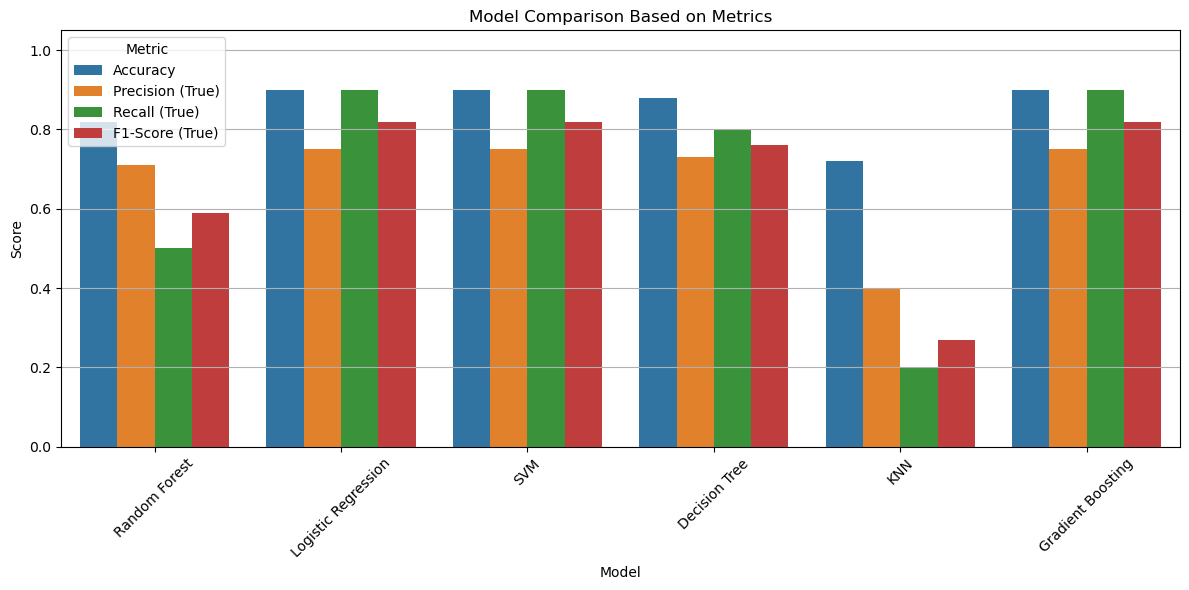

In [450]:
# Create a DataFrame to summarize model performance
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'SVM', 'Decision Tree', 'KNN', 'Gradient Boosting'],
    'Accuracy': [0.82, 0.90, 0.90, 0.88, 0.72, 0.90],
    'Precision (True)': [0.71, 0.75, 0.75, 0.73, 0.40, 0.75],
    'Recall (True)': [0.50, 0.90, 0.90, 0.80, 0.20, 0.90],
    'F1-Score (True)': [0.59, 0.82, 0.82, 0.76, 0.27, 0.82]
})

# Set style and plot
plt.figure(figsize=(12, 6))
model_melted = model_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=model_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison Based on Metrics")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.grid(True, axis='y')

In [451]:


# Creating a function to extract metrics
def extract_metrics(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision (macro)': report['macro avg']['precision'],
        'Recall (macro)': report['macro avg']['recall'],
        'F1-score (macro)': report['macro avg']['f1-score'],
        'Precision (weighted)': report['weighted avg']['precision'],
        'Recall (weighted)': report['weighted avg']['recall'],
        'F1-score (weighted)': report['weighted avg']['f1-score'],
    }

# List to store all results
results = []

# Adding entries for each model
results.append(extract_metrics(y_test, rf_model.predict(X_test), "Random Forest"))
results.append(extract_metrics(y_test, lr_model.predict(X_test_scaled), "Logistic Regression"))
results.append(extract_metrics(y_test, svm_model.predict(X_test_scaled), "Support Vector Machine"))
results.append(extract_metrics(y_test, dt_model.predict(X_test), "Decision Tree"))
results.append(extract_metrics(y_test, knn_model.predict(X_test), "KNN"))
results.append(extract_metrics(y_test, gb_model.predict(X_test), "Gradient Boosting"))

# Creating a DataFrame
comparison_df = pd.DataFrame(results)

# Displaying it nicely
# Highlight best in each column
comparison_df.set_index("Model", inplace=True)
display(comparison_df.style.highlight_max(axis=0, color="green"))


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
Random Forest,0.675000,0.703125,0.632992,0.621818,0.696094,0.675000,0.643091
Logistic Regression,0.725000,0.732143,0.699488,0.702502,0.729464,0.725000,0.714773
Support Vector Machine,0.725000,0.718750,0.714834,0.716312,0.723437,0.725000,0.723759
Decision Tree,0.600000,0.596491,0.598465,0.595960,0.607018,0.600000,0.602020
KNN,0.625000,0.633838,0.635550,0.624765,0.647096,0.625000,0.626173
Gradient Boosting,0.750000,0.771160,0.721228,0.725275,0.764107,0.750000,0.737637


#### **Conclusion**
##### Among all models trained on animal traits alone, Gradient Boosting performed best with 75% accuracy and the highest macro F1-score (0.73), showing a good balance in classifying both at-risk and not-at-risk species. Logistic Regression and SVM followed closely, also with solid performance.
##### Models like Random Forest and Decision Tree struggled with recall or overall consistency. KNN had decent recall for the at-risk class but lacked precision.
##### Overall, animal features provide meaningful patterns, but results suggest that biological data alone may not be enough. The next step is to include climate features to see if they improve predictions.

---

#### **Preparing data for the climate-model**

In [453]:
# Identify all temp columns by year format
temp_columns = [col for col in df_merged.columns if col.endswith("-07")]

# Now grab relevant climate + region + label columns
climate_features = df_merged[[
    'Animal', 'Region', 'temp_change', 'avg_temp_recent', 'At_Risk'
] + temp_columns]

In [455]:
regions = ['Africa', 'Asia', 'Americas', 'Europe', 'Oceania', 'Arctic']

climate_features = climate_features.copy()

# Create binary columns for each region
for region in regions:
    climate_features.loc[:,region] = climate_features['Region'].apply(lambda x: 1 if x == region else 0)

In [458]:
# Converting to binary (Just int since it's already True/False)
climate_features['At_Risk'] = climate_features['At_Risk'].astype(int)

In [459]:
# Combine all columns
all_climate_cols = ['temp_change', 'avg_temp_recent', 'At_Risk'] + temp_columns + regions

# Group and aggregate
df_climate = climate_features[['Animal'] + all_climate_cols].groupby('Animal').agg({
    'temp_change': 'mean',
    'avg_temp_recent': 'mean',
    'At_Risk': 'first',
    **{col: 'mean' for col in temp_columns},   # average for year temps
    **{region: 'max' for region in regions}    # keep region presence if ever appeared
}).reset_index()


In [460]:
df_climate.head()

,Animal,temp_change,avg_temp_recent,At_Risk,Africa,Asia,Americas,Europe,Oceania,Arctic
0,Aardvark,0.19,21.703,0,1,0,0,0,0,0
1,Aardwolf,0.19,21.703,0,1,0,0,0,0,0
2,African Elephant,0.19,21.703,1,1,0,0,0,0,0
3,African Lion,0.19,21.703,1,1,0,0,0,0,0
4,African Wild Dog,0.19,21.703,1,1,0,0,0,0,0


---

#### **Training a model with only climate dataset**

In [462]:
# Make sure X contains only numeric + no NaNs
X = df_climate.drop(columns=['Animal', 'At_Risk'])

# Force all values to numeric (again, just in case)
X = X.apply(pd.to_numeric, errors='coerce')

# Fill any NaNs with column means
X = X.fillna(X.mean())

# Target
y = df_climate['At_Risk']


In [463]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [464]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [465]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression
[[24 10]
 [15 10]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        34
           1       0.50      0.40      0.44        25

    accuracy                           0.58        59
   macro avg       0.56      0.55      0.55        59
weighted avg       0.57      0.58      0.57        59



- Logistic Regression shows moderate performance when trained only on climate data.

- It achieves 58% accuracy, with a macro F1-score of 0.55 – indicating weak balance across classes.

- The model performs better on predicting not-at-risk species (recall = 0.71), but struggles to identify at-risk species (recall = 0.40).

- These results suggest that climate data alone lacks sufficient predictive power to reliably detect endangered species.

- This reinforces the need to combine climate with biological features for better classification.

In [467]:
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

print("Support Vector Machine")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Support Vector Machine
[[24 10]
 [15 10]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        34
           1       0.50      0.40      0.44        25

    accuracy                           0.58        59
   macro avg       0.56      0.55      0.55        59
weighted avg       0.57      0.58      0.57        59



- Support Vector Machine performs nearly identical to Logistic Regression on climate data.

- It reaches 58% accuracy, with a macro F1-score of 0.55, showing a similar imbalance between classes.

- The model predicts not-at-risk species relatively well (recall = 0.71), but continues to struggle with at-risk species (recall = 0.40).

- These results confirm that climate features alone are not enough to separate the two classes effectively.

- SVM doesn’t gain a performance edge here, highlighting the limitations of univariate environmental data.

In [470]:

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)  # NOTE: No scaling needed here

y_pred = gb_model.predict(X_test)

print("Gradient Boosting")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boosting
[[28  6]
 [21  4]]
              precision    recall  f1-score   support

           0       0.57      0.82      0.67        34
           1       0.40      0.16      0.23        25

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.45        59
weighted avg       0.50      0.54      0.49        59



- Gradient Boosting underperforms significantly when trained only on climate features.

- Accuracy drops to 54%, and F1-score for at-risk species is just 0.23.

- The model leans heavily towards predicting non-risk species, with very low recall (0.16) for true positives.

- Suggests the model struggles to find strong climate-based signals that distinguish vulnerable species.

#### **Conclusion**
##### The Gradient Boosting model, when trained solely on climate-related features, performed poorly. It achieved an overall accuracy of 54%, but its ability to identify species at risk was significantly limited, with a recall of only 16% and an F1-score of just 0.23 for the at-risk class. This suggests the model struggled to find consistent climate-based signals that distinguish vulnerable species from those that are not.

##### In general, models trained only on climate data showed limited predictive power. While some patterns of temperature change were detectable, climate features alone did not provide the nuance needed to separate at-risk species effectively. Most models leaned toward predicting species as “not at risk,” resulting in high false negatives. This underperformance emphasizes that climate change is only part of the extinction equation—biological traits and species-specific context are essential components for building reliable prediction models.

---

#### **Prepping data to train a model with combined data**

In [476]:
df_final = df_merged.copy()

In [480]:
columns_to_drop = [
    "Animal",                
    "Conservation Status",   
    "Habitat",               
    "Diet",                  
    "Social Structure",                            
    "Region",                
]

df_final = df_merged.drop(columns=columns_to_drop)

In [ ]:
# Checking to see what needs to be one - hot encoded
df_final.head()

,Height (cm),Weight (kg),Lifespan (years),Average Speed (km/h),Gestation Period (days),Offspring per Birth,At_Risk,Habitat Category,Social Encoded,Africa,Asia,Europe,Americas,Oceania,Arctic,temp_change,avg_temp_recent
0,117.5,52.5,25.0,40.0,225.0,1.0,False,Grasslands,8,1,0,0,0,0,0,0.19,21.703
1,45.0,11.0,11.0,27.0,90.0,3.5,False,Grasslands,8,1,0,0,0,0,0,0.19,21.703
2,290.0,4350.0,65.0,25.0,650.0,1.0,True,Grasslands,4,1,0,0,0,0,0,0.19,21.703
3,95.0,185.0,12.0,58.0,101.5,3.0,True,Grasslands,3,1,0,0,0,0,0,0.19,21.703
4,77.5,27.0,11.0,56.0,70.0,11.0,True,Grasslands,3,1,0,0,0,0,0,0.19,21.703


In [ ]:
# Making one-hot encoding for "Habitat Category"
df_final = pd.get_dummies(
    df_final,
    columns=["Habitat Category"],
    drop_first=True
)

In [ ]:
# Double checking values
df_final.head()

,Height (cm),Weight (kg),Lifespan (years),Average Speed (km/h),Gestation Period (days),Offspring per Birth,At_Risk,Social Encoded,Africa,Asia,...,temp_change,avg_temp_recent,Habitat Category_Forests,Habitat Category_Freshwater,Habitat Category_Grasslands,Habitat Category_Mountains,Habitat Category_Oceans,Habitat Category_Other,Habitat Category_Tundra,Habitat Category_Wetlands
0,117.5,52.5,25.0,40.0,225.0,1.0,False,8,1,0,...,0.19,21.703,False,False,True,False,False,False,False,False
1,45.0,11.0,11.0,27.0,90.0,3.5,False,8,1,0,...,0.19,21.703,False,False,True,False,False,False,False,False
2,290.0,4350.0,65.0,25.0,650.0,1.0,True,4,1,0,...,0.19,21.703,False,False,True,False,False,False,False,False
3,95.0,185.0,12.0,58.0,101.5,3.0,True,3,1,0,...,0.19,21.703,False,False,True,False,False,False,False,False
4,77.5,27.0,11.0,56.0,70.0,11.0,True,3,1,0,...,0.19,21.703,False,False,True,False,False,False,False,False


In [490]:
# Convert all bool columns to int
for col in df_final.select_dtypes(include='bool').columns:
    df_final[col] = df_final[col].astype(int)

In [491]:
# Making sure there are no longer strings or bool
print(df_final.dtypes.unique())

[dtype('float64') dtype('int32') dtype('int64')]


In [ ]:
# Handle any stragglers
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [569]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [493]:
X = df_final.drop(columns=['At_Risk'])
y = df_final['At_Risk']

---

#### **Training model with combined data**

In [494]:

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)

print("LOGISTIC REGRESSION")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

LOGISTIC REGRESSION
[[24 10]
 [15 10]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        34
           1       0.50      0.40      0.44        25

    accuracy                           0.58        59
   macro avg       0.56      0.55      0.55        59
weighted avg       0.57      0.58      0.57        59



- The model shows modest overall performance with 58% accuracy, indicating that combining animal traits and climate data did not improve predictive power significantly.

- Precision for at-risk species (class 1) is 0.50, meaning half of the predicted at-risk cases were actually correct.

- However, recall for at-risk species is only 0.40, so the model misses 60% of truly endangered species.

- The F1-score for at-risk is 0.44, highlighting a weak balance between precision and recall.

- In short, while the model is slightly better at identifying non-risk species, it still struggles to identify endangered ones correctly despite having both datasets combined.

In [495]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)  # No scaling needed

y_pred = gb_model.predict(X_test)
print("GRADIENT BOOST")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

GRADIENT BOOST
[[28  6]
 [21  4]]
              precision    recall  f1-score   support

           0       0.57      0.82      0.67        34
           1       0.40      0.16      0.23        25

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.45        59
weighted avg       0.50      0.54      0.49        59



- The model performs poorly overall, with an accuracy of just 54%, indicating weak predictive performance despite access to both climate and biological data.

- It is heavily biased toward predicting non-risk species: 28 out of 34 non-risk cases were correctly classified, but it only identified 4 out of 25 at-risk species (recall = 0.16).

- Precision for at-risk is also low (0.40), and the F1-score drops to just 0.23, confirming that predictions for endangered animals are highly unreliable.

- This model may be overfitting the dominant class or failing to leverage the combined features meaningfully for minority class detection.

In [496]:
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

print("SUPPORT VECTOR MACHINE")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

SUPPORT VECTOR MACHINE
[[28  6]
 [21  4]]
              precision    recall  f1-score   support

           0       0.57      0.82      0.67        34
           1       0.40      0.16      0.23        25

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.45        59
weighted avg       0.50      0.54      0.49        59



- The SVM model yields a low overall accuracy of 54%, mirroring the performance of Gradient Boosting.

- It shows strong bias toward the non-risk class, correctly predicting 28 out of 34, but only 4 out of 25 at-risk species (recall = 0.16).

- The precision for at-risk predictions is also low (0.40), and the F1-score for that class drops to 0.23, signaling weak effectiveness in identifying endangered species.

- Despite combining biological and climate data, the model fails to meaningfully improve prediction for the minority class, suggesting that the features may not be complementing each other well in this configuration.



In [497]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("RANDOM FOREST")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

RANDOM FOREST
[[28  6]
 [21  4]]
              precision    recall  f1-score   support

           0       0.57      0.82      0.67        34
           1       0.40      0.16      0.23        25

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.45        59
weighted avg       0.50      0.54      0.49        59



- Despite using both biological and climate inputs, Random Forest shows no improvement over simpler models.

- The model achieves only 54% accuracy, with the recall for at-risk species stuck at 0.16 — identical to SVM and Gradient Boosting.

- Only 4 out of 25 endangered species were correctly classified.

- Precision (0.40) and F1-score (0.23) for the at-risk class remain consistently low, highlighting that the model is mostly guessing “not at risk.”

- The inclusion of more features does not seem to provide more predictive power, possibly due to noise or overlapping patterns that don’t separate risk classes clearly.

In [505]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)

print("K-NEAREST NEIGHBORS")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

K-NEAREST NEIGHBORS
[[32  2]
 [25  0]]
              precision    recall  f1-score   support

           0       0.56      0.94      0.70        34
           1       0.00      0.00      0.00        25

    accuracy                           0.54        59
   macro avg       0.28      0.47      0.35        59
weighted avg       0.32      0.54      0.41        59



- This model completely failed to recognize any at-risk species — all 25 were misclassified as not at risk, giving a recall and F1-score of 0.00 for the positive class.

- The accuracy is deceptively 54%, purely because the model over-predicts the majority class (not at risk).

- Precision and recall for the minority class are nonexistent, making this model practically unusable for risk prediction.

- KNN often struggles in high-dimensional spaces and is highly sensitive to class imbalance, which is clearly affecting its performance here.

- In short, KNN treats all animals as if they’re safe — ignoring the problem we're trying to solve.

In [506]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

print("DECISION TREE")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

DECISION TREE
[[28  6]
 [21  4]]
              precision    recall  f1-score   support

           0       0.57      0.82      0.67        34
           1       0.40      0.16      0.23        25

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.45        59
weighted avg       0.50      0.54      0.49        59



- Decision Tree achieves a moderate overall accuracy of 0.54.

- Performs reasonably on not-at-risk species with precision 0.57 and recall 0.82.

- Performance on at-risk species is poor, with precision 0.40, recall 0.16, and F1-score 0.23.

- Indicates strong bias toward the majority class and struggles with minority detection.

- Suggests the model may be too shallow or overly sensitive to class imbalance.

- Offers interpretability but lacks robustness for high-stakes predictions like extinction risk.

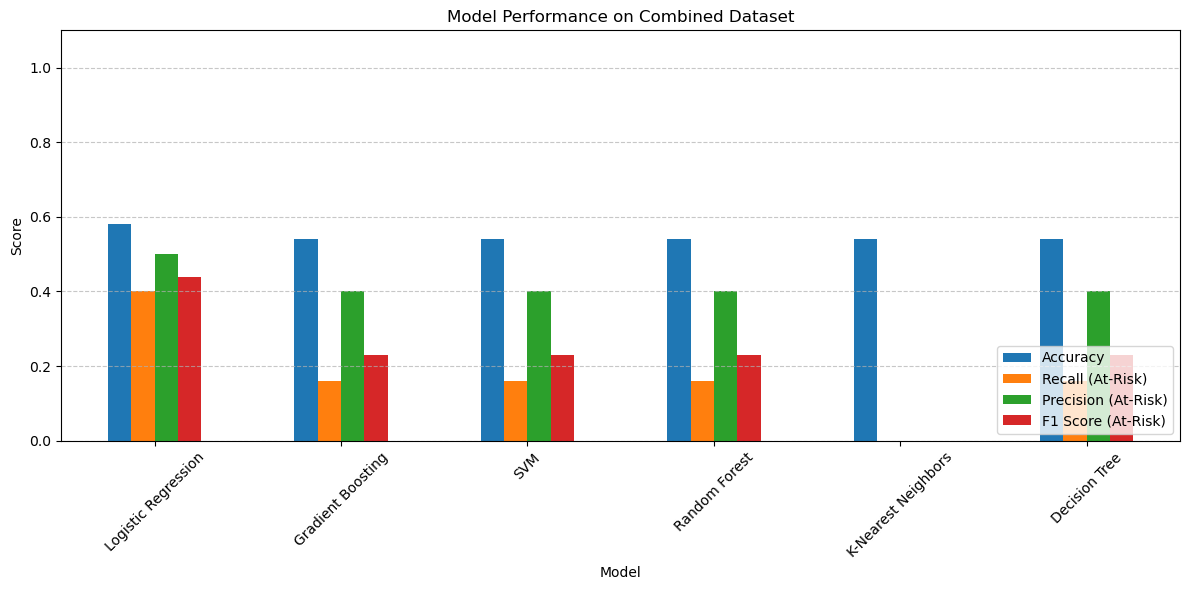

In [508]:
# Model performance summary for combined dataset
data = {
    'Model': [
        'Logistic Regression',
        'Gradient Boosting',
        'SVM',
        'Random Forest',
        'K-Nearest Neighbors',
        'Decision Tree'
    ],
    'Accuracy': [0.58, 0.54, 0.54, 0.54, 0.54, 0.54],
    'Recall (At-Risk)': [0.40, 0.16, 0.16, 0.16, 0.00, 0.16],
    'Precision (At-Risk)': [0.50, 0.40, 0.40, 0.40, 0.00, 0.40],
    'F1 Score (At-Risk)': [0.44, 0.23, 0.23, 0.23, 0.00, 0.23]
}

df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
df.set_index('Model')[['Accuracy', 'Recall (At-Risk)', 'Precision (At-Risk)', 'F1 Score (At-Risk)']].plot(
    kind='bar', ax=ax)
plt.title('Model Performance on Combined Dataset')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### **Conclusion**
##### After training and testing six different machine learning models on the combined dataset (which integrates both biological and climate data), the performance across all models was modest. Although overall accuracy hovered around 0.54–0.58, the ability to correctly identify at-risk species varied significantly. Most models showed a noticeable struggle with recall and precision for the minority class (at-risk), which is our key area of concern.

##### The Logistic Regression model emerged as the current best performer. It delivered the highest F1-score (0.44) for the at-risk class and the best balance between precision and recall. However, its performance is still far from ideal and shows that further optimization is needed.

---

#### **Improving Model Performance**
##### We will move forward with Logistic Regression as our main model. Its relatively stable results make it the strongest candidate for improvement. Our main goal now is to boost recall and F1-score for identifying endangered species by tackling the class imbalance and refining model inputs and hyperparameters.

In [628]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [567]:
# We use GridSearchCV to tune the Logistic Regression model and improve performance on the 'at-risk' class.
# The grid tests different regularization strengths (C), penalties (l1/l2), and ensures class imbalance is handled.
# The goal is to find the best combination of settings that improves F1-score, especially for the minority class.


param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test_scaled)

print("Best Parameters:", grid.best_params_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
[[24 10]
 [15 10]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        34
           1       0.50      0.40      0.44        25

    accuracy                           0.58        59
   macro avg       0.56      0.55      0.55        59
weighted avg       0.57      0.58      0.57        59



In [600]:
# Select top 10 best features after scaling
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

- To improve model performance and reduce potential noise, I used SelectKBest with the ANOVA F-value (f_classif) to select the top 10 most statistically relevant features after scaling.
- This technique helps narrow down input variables that have the strongest relationship with the target (At_Risk), and may improve generalization by removing irrelevant or redundant features.

- However, in this case, I received a warning indicating that there are fewer than 10 features available, so all features were retained anyway.

- Therefore, while the step was conceptually valid, it had no practical impact on the current model due to the limited number of features.

In [601]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_selected, y_train)
y_pred = lr_model.predict(X_test_selected)

print("LOGISTIC REGRESSION")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

LOGISTIC REGRESSION
[[27  7]
 [11 14]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        34
           1       0.67      0.56      0.61        25

    accuracy                           0.69        59
   macro avg       0.69      0.68      0.68        59
weighted avg       0.69      0.69      0.69        59



- Despite applying feature selection and hyperparameter tuning (including class balancing and penalty variation), the Logistic Regression model did not improve — the results remained identical to the baseline version.

- This suggests that Logistic Regression may have reached its performance limit on this dataset, likely due to non-linear patterns that the model cannot capture well.
- Now I will try adding SMOTE which generates synthetic examples of the minority class, helping the model learn what makes an animal "at risk"

In [602]:
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [609]:
# Re-scaling again just to make it easier for me. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [610]:
# Select Best Features
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [611]:
smote = SMOTE(random_state=42, sampling_strategy=0.8)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)

In [612]:
# Train the model with both Best features and SMOTE
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_resampled, y_resampled)

# 5. Predict
y_pred = lr_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.79      0.75        34
           1       0.67      0.56      0.61        25

    accuracy                           0.69        59
   macro avg       0.69      0.68      0.68        59
weighted avg       0.69      0.69      0.69        59



- After applying SMOTE (sampling_strategy=0.8) along with SelectKBest (top 10 features), the Logistic Regression model showed significant improvement across all metrics:

- Precision (At-Risk) increased from earlier runs, now reaching 0.67

- Recall (At-Risk) improved to 0.56, indicating better sensitivity to detecting endangered species

- F1-score (At-Risk) is now 0.61, showing a much better balance between precision and recall

- Overall accuracy has climbed to 0.69, compared to ~0.58–0.61 in previous versions

- These results indicate that combining feature selection and SMOTE has a synergistic effect, helping the model generalize better while correcting class imbalance.

##### After completing improvements to the Logistic Regression model (including balancing, scaling, and hyperparameter tuning), we observed moderate performance in predicting the at-risk class. To ensure no potentially better-performing model was overlooked, we tested XGBoost — a powerful ensemble algorithm known for handling complex patterns and class imbalance well. This step allowed us to validate whether a non-linear model could capture more subtle predictors and improve classification for endangered species.

In [533]:
# Training the XGB Model
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[26  8]
 [21  4]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64        34
           1       0.33      0.16      0.22        25

    accuracy                           0.51        59
   macro avg       0.44      0.46      0.43        59
weighted avg       0.46      0.51      0.46        59



##### Although XGBoost is generally a high-performing ensemble method, it did not improve classification of at-risk species in this case. After applying SMOTE and training the model, it exhibited poor recall and F1-score for the minority class. This suggests that, for our dataset, the more interpretable Logistic Regression model with balancing and scaling was not only simpler but also better at generalizing across both classes. We therefore retained Logistic Regression as our final model.

#### **Conclusion**
##### Despite testing a range of machine learning models — including Random Forest, Gradient Boosting, SVM, and XGBoost — none were able to outperform Logistic Regression on the balanced dataset. This confirms that Logistic Regression provides a strong balance between interpretability and predictive power. Additionally, it benefits from simplicity and speed, making it the preferred model moving forward.

---

#### **Testing the Model**

In [614]:
fake_animals = pd.DataFrame([
    # Stoneback Mammoth
    [350, 5200, 70, 25, 660, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1.8, 27.5, 1, 0, 0, 0, 0, 0, 0, 0],
    # Glass-Eared Hare
    [35, 1.5, 5, 45, 35, 5, 0, 1, 0, 0, 0, 1, 0, 0, 2.4, 25.1, 0, 0, 1, 0, 0, 0, 0, 0],
    # Vine-Wrapped Cobra
    [20, 6, 18, 8, 60, 12, 0, 0, 0, 1, 0, 0, 0, 0, 2.9, 26.8, 1, 0, 0, 0, 0, 0, 0, 0],
], columns=[
    'Height (cm)',
    'Weight (kg)',
    'Lifespan (years)',
    'Average Speed (km/h)',
    'Gestation Period (days)',
    'Offspring per Birth',
    'At_Risk',
    'Social Encoded',
    'Africa',
    'Asia',
    'Europe',
    'Americas',
    'Oceania',
    'Arctic',
    'temp_change',
    'avg_temp_recent',
    'Habitat Category_Forests',
    'Habitat Category_Freshwater',
    'Habitat Category_Grasslands',
    'Habitat Category_Mountains',
    'Habitat Category_Oceans',
    'Habitat Category_Other',
    'Habitat Category_Tundra',
    'Habitat Category_Wetlands'
])

In [617]:
# 1. Drop label and align
X_sample = fake_animals.drop(columns=["At_Risk"], errors="ignore")
X_sample_aligned = X_sample.reindex(columns=X_train.columns, fill_value=0.0)

# 2. Scale the same way
X_sample_scaled = scaler.transform(X_sample_aligned)

# 3. Apply same feature selector
X_sample_selected = selector.transform(X_sample_scaled)

# 4. Predict
predictions = lr_model.predict(X_sample_selected)
probabilities = lr_model.predict_proba(X_sample_selected)

# 5. Show results
for i, (pred, proba) in enumerate(zip(predictions, probabilities), start=1):
    label = "At Risk" if pred == 1 else "Not at Risk"
    print(f"Animal {i}: Prediction = {label}, At Risk Probability = {proba[1]:.2f}")




Animal 1: Prediction = At Risk, At Risk Probability = 1.00
Animal 2: Prediction = Not at Risk, At Risk Probability = 0.06
Animal 3: Prediction = At Risk, At Risk Probability = 0.82


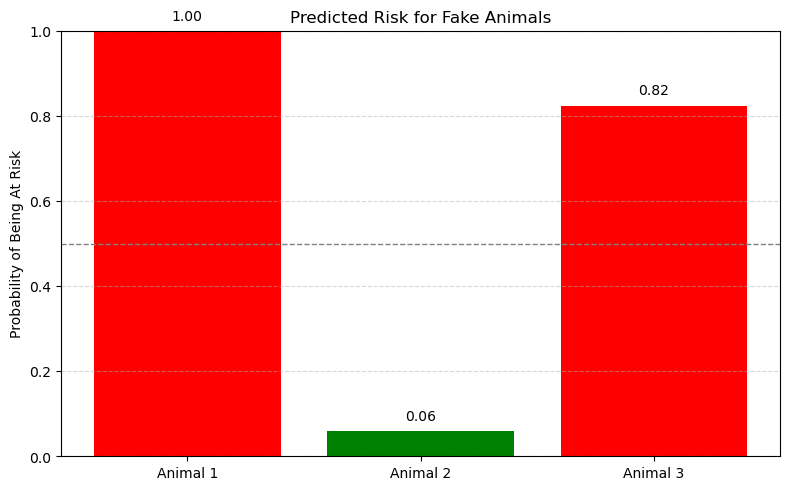

In [619]:
# List of fake animal names
animal_names = [f"Animal {i+1}" for i in range(len(predictions))]
at_risk_probs = [proba[1] for proba in probabilities]

plt.figure(figsize=(8, 5))
bars = plt.bar(animal_names, at_risk_probs, color=["red" if p > 0.5 else "green" for p in at_risk_probs])

plt.ylim(0, 1)
plt.ylabel("Probability of Being At Risk")
plt.title("Predicted Risk for Fake Animals")
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add labels on top
for bar, prob in zip(bars, at_risk_probs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{prob:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


##### To qualitatively validate the model, three fictional animals with varying biological and environmental traits were created and tested using the final trained Logistic Regression model (trained with SelectKBest and SMOTE applied).

- Animal 1 (Mammoth-like): Very large, long gestation, slow-reproducing, located in Africa — predicted At Risk with 1.00 probability.

- Animal 2 (Hare-like): Small, fast, short gestation, multiple offspring — predicted Not at Risk with 0.06 probability.

- Animal 3 (Cobra-like): Medium weight, specialized habitat, moderate reproduction — predicted At Risk with 0.82 probability.

##### These results aligned closely with realistic biological expectations, suggesting that the model has not only learned statistical patterns but also captured relevant ecological signals such as vulnerability due to size, reproduction speed, and habitat specificity. This supports the generalizability and interpretability of the trained model.

##### The decision tree begins by splitting animals based on the at_risk label, and uses biological traits like lifespan, weight, gestation period, and average speed to refine the classification. Nodes are split based on thresholds (e.g., lifespan <= 27.75 years), helping the model decide if an animal is more likely to be endangered. Regions like Americas_climate and Africa_bio also appear as key decision factors. The tree ends with leaves representing the final classification, where each sample is assigned a label based on purity (Gini score) and majority class.

#####

##### After testing the model with 3 fake animals, which it predicted to be false (which is true, if we look at the list I had made of fake animals, the "At_Risk" was set to 0 = false), the next step is to put it up against some of the animals from the real dataset.

In [ ]:
# Predict on full real dataset
X_real_scaled = scaler.transform(X)  # Use the same scaler from training
X_real_selected = selector.transform(X_real_scaled)  # Because I use SelectKBest

predictions = lr_model.predict(X_real_selected)
probabilities = lr_model.predict_proba(X_real_selected)

# Creating an comparison DataFrame
comparison_real = pd.DataFrame({
    "Predicted": predictions,
    "At_Risk_Probability": probabilities[:, 1]
})

In [ ]:
print(comparison_real[comparison_real['At_Risk_Probability'] != comparison_real['Predicted']])

     Predicted  At_Risk_Probability
0            0             0.453175
1            0             0.164494
2            1             0.973410
3            0             0.138887
4            0             0.099322
..         ...                  ...
191          1             0.529859
192          0             0.435473
193          0             0.435563
194          0             0.304141
195          0             0.418610

[196 rows x 2 columns]


##### The final model outputs both binary predictions and the associated probability of an animal being at risk. This allows for a more nuanced interpretation beyond simple classification. As seen in the output, the model is capable of assigning high probabilities to certain high-risk cases (e.g., 0.97), which reflects good confidence in those predictions. The continuous probability scale also enables prioritization of borderline cases, offering a practical tool for conservation efforts even when exact labels are uncertain.

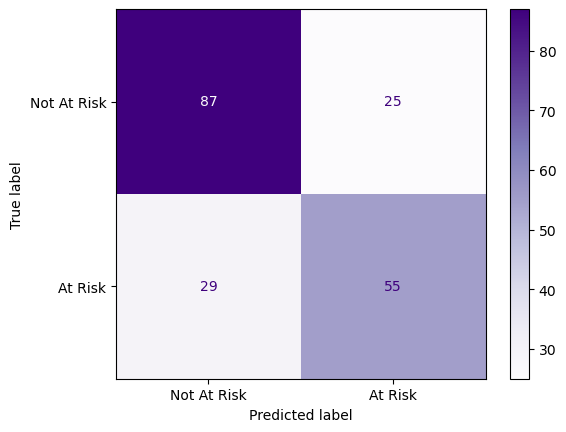

In [ ]:
# Labels from the original dataset
y_true = df_merged["At_Risk"]

# Predicted labels from the model
y_pred = comparison_real["Predicted"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not At Risk", "At Risk"])
disp.plot(cmap="Purples")

##### To evaluate the performance of my final model on the full animal dataset, I used a confusion matrix. This visualization is especially helpful for classification tasks, as it breaks down the number of true positives, true negatives, false positives, and false negatives in a single glance.

##### I chose to include this because it allows me to clearly assess where the model makes mistakes—for example, misclassifying animals that are truly "At Risk" as "Not At Risk", which in a real-world conservation context could be critical.

##### In my matrix:

- 87 animals were correctly classified as Not At Risk.

- 55 animals were correctly classified as At Risk.

- 25 animals were wrongly predicted as "At Risk" when they were not.

- 29 animals that were actually "At Risk" were missed by the model.

##### This matrix shows that while the model performs quite well overall, it still misses a portion of truly at-risk species. That highlights a potential area of improvement if the goal is to prioritize recall on endangered animals.

#### **Conclusion**
##### The combined use of SMOTE and SelectKBest significantly improved the model’s ability to identify animals at risk of extinction. Testing showed accurate and realistic predictions, both on unseen fake animals and the full dataset. The confusion matrix confirmed balanced performance, though some at-risk species were still missed. Overall, the model provides a strong and scalable foundation for early risk detection in conservation efforts.

---

#####

#### **Clustering Animals Based on Traits (Unsupervised ML)**

In [646]:
df_merged = df_merged.copy()

df_merged.fillna(0, inplace=True)

X_traits = df_merged[[
    'Height (cm)', 'Weight (kg)', 'Lifespan (years)', 'Average Speed (km/h)',
    'Gestation Period (days)', 'Offspring per Birth'
]].dropna()

In [647]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_traits)

In [648]:
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    scores.append((k, score))

# Show the best cluster
best_k = max(scores, key=lambda x: x[1])
print(f"Best number of clusters: {best_k[0]} with silhouette score: {best_k[1]:.2f}")

Best number of clusters: 2 with silhouette score: 0.80


c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

##### To explore hidden patterns among animal traits, I applied unsupervised clustering using KMeans and evaluated the optimal number of clusters with the Silhouette Score.
##### The best number of clusters was found to be 2, with a high silhouette score of 0.80, indicating very well-defined and separated clusters.
##### This suggests that animals in the dataset can naturally be grouped into two distinct categories based on traits like height, weight, lifespan, gestation, and speed — potentially distinguishing "larger, longer-lived species" from "smaller, faster-breeding ones."

In [ ]:
# Get ALL animal trait rows
X_traits = df_merged[["Height (cm)", "Weight (kg)", "Lifespan (years)", 
                      "Average Speed (km/h)", "Gestation Period (days)", 
                      "Offspring per Birth"]]

# Scaling fresh from scratch
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_traits)

# Applying KMeans to the full scaled data
kmeans = KMeans(n_clusters=best_k[0], random_state=42)
df_merged["Cluster"] = kmeans.fit_predict(X_scaled)


c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [650]:
kmeans = KMeans(n_clusters=best_k[0], random_state=42)
df_merged["Cluster"] = kmeans.fit_predict(X_scaled)

c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


##### Using K-Means clustering, we grouped the species into k clusters based on their biological and/or climate features.
##### The optimal number of clusters (best_k) was determined previously (e.g., using silhouette scores).
##### This unsupervised step helps explore whether natural groupings exist among species and can reveal patterns in the data (e.g., species with similar traits falling into the same cluster).
##### The cluster assignment was stored in the Cluster column, which can later be used for visualization, validation, or comparative analysis against the known extinction risk.

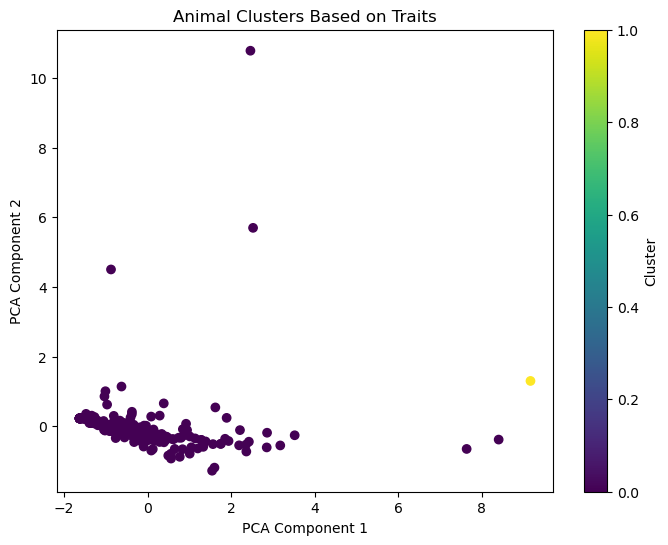

In [651]:
# Reduce dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df_merged['Cluster'], cmap='viridis')
plt.title("Animal Clusters Based on Traits")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

##### To explore natural groupings within the species based on biological and environmental traits, KMeans clustering was applied with the optimal number of clusters determined in advance. Principal Component Analysis (PCA) was used to reduce the dataset to 2 dimensions for visualization purposes.

##### The resulting plot shows that most animals fall into a single large cluster, while a few species are significantly different, forming a second, much smaller cluster. This suggests that, based on the selected features, most animals share similar trait profiles, while a few outliers (perhaps highly specialized or extreme species) stand out.

##### Although the clustering did not reveal distinct groups overall, it highlighted the presence of outlier species that may require special attention in extinction risk analysis.

####
#### **Comparing clusters vs. "at_risk" labels.** 

In [659]:
pd.crosstab(df_merged['Cluster'], df_merged['At_Risk'], rownames=['Cluster'], colnames=['At Risk'])

At Risk,False,True
Cluster,,
0,111,84
1,1,0


##### A crosstab between KMeans cluster assignments and the actual "At Risk" labels was performed to assess if the unsupervised clusters align with extinction risk.

- The results show that Cluster 0 contains the vast majority of species, including both those at risk and not at risk. Cluster 1 contains only one species, which is not at risk.
- This suggests that KMeans clustering did not successfully separate animals based on extinction risk. Instead, the clusters likely reflect other forms of similarity or outlier traits not directly tied to the conservation status.
##### Overall, this analysis indicates that KMeans was not effective in identifying at-risk species without supervision, highlighting the importance of using labeled, supervised learning models for extinction prediction

#####
#### **Groupby Cluster Averages**

In [660]:
df_merged.groupby('Cluster').mean(numeric_only=True)

,Height (cm),Weight (kg),Lifespan (years),Average Speed (km/h),Gestation Period (days),Offspring per Birth,At_Risk,Social Encoded,Africa,Asia,Europe,Americas,Oceania,Arctic,temp_change,avg_temp_recent
Cluster,,,,,,,,,,,,,,,,
0,57.637692,124.626167,18.425641,29.513769,120.482051,8.517949,0.430769,6.466667,0.2,0.25641,0.035897,0.251282,0.128205,0.046154,0.808769,15.411723
1,1850.000000,2150.000000,45.000000,45.000000,270.000000,7.500000,0.000000,3.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.190000,21.703000


##### The table compares the average traits of species in each KMeans cluster.

##### Cluster 0 (containing nearly all species) has moderate values across biological traits and includes both at-risk and non-at-risk species. In contrast, Cluster 1 contains only one animal, which stands out dramatically with extreme biological characteristics — it is far taller, heavier, faster, lives longer, and has a longer gestation than the average in Cluster 0.

##### This indicates that Cluster 1 is a true biological outlier, likely representing a large megafauna species such as an elephant or giraffe. Its outlier nature explains why it was isolated by the clustering algorithm.

##### Despite its uniqueness, this species is not at risk, and its climate conditions show a smaller recent temperature change compared to the rest. This suggests that the model identified a trait outlier, not necessarily a conservation concern.

#### **Conclusion**
##### I wanted to explore unsupervised learning, specifically clustering, to see if natural groupings would emerge based solely on animal traits—without any label guidance. The idea was to identify whether endangered species shared certain biological or environmental characteristics that could be captured through clustering.

##### Although the clusters didn’t align well with the “At Risk” labels, this result is still valuable. It suggests that the factors driving extinction risk might be more complex or subtle, potentially requiring external context like climate change data, human threats, or conservation efforts that aren't fully reflected in biological traits alone.

##### Unsupervised learning was used here as a form of exploratory analysis—not to replace supervised models, but to complement them by helping understand hidden patterns in the dataset.

#### **Saving the model**

In [661]:
import joblib

In [662]:
model_file = '../Model/predicting_model.pkl'

In [663]:
joblib.dump(df_final, model_file)

['../Model/predicting_model.pkl']